In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
class WordDataset:
    def __init__(self, sentences, word2ind: dict):
        self.data = sentences
        self.word2ind = word2ind
        self.unk_id = self.word2ind['<unk>']
        self.bos_id = self.word2ind['<bos>']
        self.eos_id = self.word2ind['<eos>']
        self.pad_id = self.word2ind['<pad>']

    def __getitem__(self, idx: int):
        processed_text = self.data['text'][idx].lower().translate(str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [self.word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)]
        tokenized_sentence += [self.eos_id]

        return {'text': tokenized_sentence,
                'label': self.data['label'][idx]}

    def __len__(self) -> int:
        return len(self.data['label'])

In [ ]:
train_dataset = WordDataset(dataset['train'], word2ind)

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx), word2ind)

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

rnn + линейный слой

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

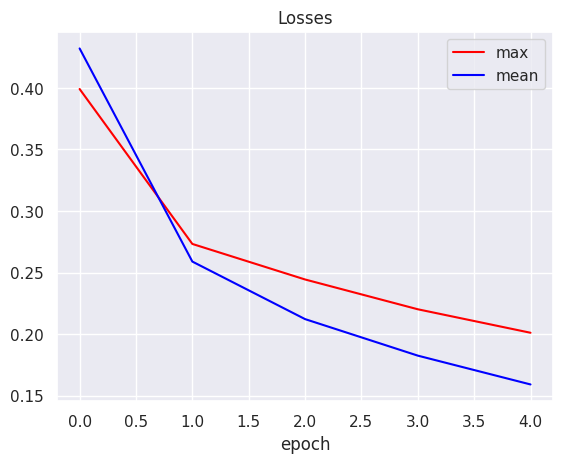

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.98
Лучшая accuracy для подхода mean: 90.72


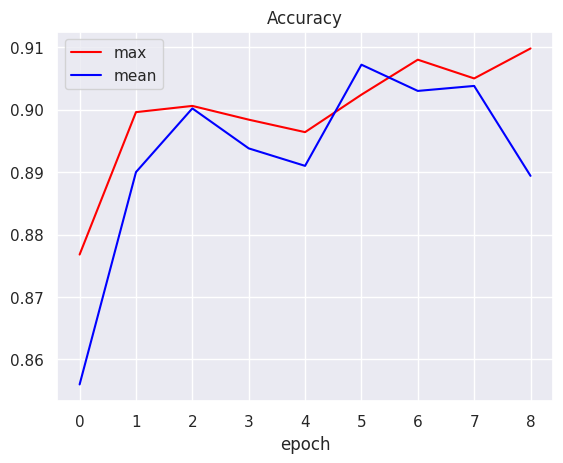

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

Используем базовый класс для проведения экспериментов

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 51.2 MB/s eta 0:00:00


In [ ]:
import lightning as L

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from torchmetrics.classification import MulticlassAccuracy
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
class Classifier(L.LightningModule):
    def __init__(self,
                 arch: str,
                 hidden_dim: int,
                 vocab_size: int,
                 learning_rate: float = 3e-05,
                 num_classes: int = 4,
                 num_layers: int = 1,
                 bidirectional: bool = False,
                 dropout_rate: float = 0,
                 aggregation_type: str = 'max',
                embedding_vectors=None):

        super().__init__()
        self.learning_rate = learning_rate
        self.aggregation_type = aggregation_type

        self.loss = nn.CrossEntropyLoss()
        self.metric = MulticlassAccuracy(num_classes=num_classes)

        self.losses = {'train': [],
                       'valid': [],
                       'test': []}
        self.metrics = {'train': [],
                        'valid': [],
                        'test': []}

        self.train_step_outputs = []
        self.valid_step_outputs = []
        self.test_step_outputs = []

        if embedding_vectors is None:
            input_dim = hidden_dim
            self.embedding = nn.Embedding(vocab_size, input_dim)
        else:
            input_dim = embedding_vectors.shape[1]
            self.embedding = nn.Embedding(vocab_size,
                                          input_dim).from_pretrained(embedding_vectors,
                                                                      freeze=False)

        if arch == 'LSTM':
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                               batch_first=True, bidirectional=bidirectional,
                               dropout=dropout_rate)
        elif arch == 'GRU':
            self.rnn = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, bidirectional=bidirectional,
                              dropout=dropout_rate)
        else:
            self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, bidirectional=bidirectional,
                              dropout=dropout_rate)
        if bidirectional:
            self.linear = nn.Linear(2 * hidden_dim, hidden_dim)
        else:
            self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(0.1)


    def forward(self, input):
        embeddings = self.embedding(input)
        output, _ = self.rnn(embeddings)
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        else:
            output = output.mean(dim=1)

        output = self.dropout(self.linear(output))
        prediction = self.projection(self.non_lin(output))

        return prediction

    def _shared_step(self, input, stage):
        X, y = input['input_ids'], input['label']
        output = self.forward(X)

        loss = self.loss(output, y)
        accuracy = self.metric(output, y)

        results = {'loss': loss, 'metric': accuracy}

        getattr(self, f'{stage}_step_outputs').append(results)

        return results

    def _shared_epoch_end(self, stage):
        outputs = getattr(self, f'{stage}_step_outputs')
        loss = torch.tensor([x['loss'].item() for x in outputs]).mean()
        metrics = torch.vstack([x['metric'] for x in outputs]).mean()

        getattr(self, f'{stage}_step_outputs').clear()

        self.losses[stage].append(loss.item())
        self.metrics[stage].append(metrics.item())

        metrics = {f'{stage}_loss': loss,
                  f'{stage}_metric': metrics}

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, 'valid')

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, 'test')

    def on_train_epoch_end(self):
        self._shared_epoch_end('train')

    def on_validation_epoch_end(self):
        self._shared_epoch_end('valid')

    def on_test_epoch_end(self):
        self._shared_epoch_end('test')

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                patience=5),
                'interval': 'epoch',
                'monitor': 'valid_loss'}

        return [optimizer], [scheduler]

In [ ]:
import pandas as pd
import plotly.express as px

Визуализация

In [ ]:
def show_plots(model):
    # Подготовка данных
    losses = pd.DataFrame({'обучение': model.losses['train'],
                           'валидация': model.losses['valid'][1:]})
    metrics = pd.DataFrame({'обучение': model.metrics['train'],
                            'валидация': model.metrics['valid'][1:]})

    # Построение графика функции потерь
    plt.figure(figsize=(10, 5))
    plt.plot(losses['обучение'], label='Обучение', color='skyblue')
    plt.plot(losses['валидация'], label='Валидация', color='orange')
    plt.title('Изменение значений функции потерь по эпохам')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение функции потерь')
    plt.legend(title="Этап:")
    plt.grid(True)
    plt.show()

    # Построение графика метрики accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['обучение'], label='Обучение', color='skyblue')
    plt.plot(metrics['валидация'], label='Валидация', color='orange')
    plt.title('Изменение значений метрики accuracy по эпохам')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение метрики')
    plt.legend(title="Этап:")
    plt.grid(True)
    plt.show()

    # Вывод значения метрики на последней эпохе
    print(f"Значение метрики на последней эпохе (валидация): {metrics['валидация'].iloc[-1]}")

Параметры для RNN.

In [ ]:
num_epoch = 5
hidden_dim = 128
dropout_rate = 0
num_layers = 1
bidirectional = False
arch = 'RNN'
aggregation_type = 'max'
learning_rate = 3e-5

In [ ]:
model = Classifier(arch=arch,
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [ ]:
trainer = L.Trainer(max_epochs=num_epoch,
                    accelerator='gpu',
                    log_every_n_steps=10,
                    gradient_clip_val=0.5)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Модуль данных:

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
def collate_fn_with_padding(input_batch, pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch)
    labels = torch.LongTensor([x['label'] for x in input_batch])

    return {'input_ids': sequences,
            'label': labels}

In [ ]:
BATCH_SIZE = 128

In [ ]:
class NewsDataModule(L.LightningDataModule):
    def __init__(self, data, word2ind: dict, batch_size: int = BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size
        self.data_train = data['train'].to_dict()

        # Use the `train_test_split` method from the Hugging Face Datasets library
        # The Hugging Face `Dataset` object has its own `train_test_split` method
        self.data_val, self.data_test = data['test'].train_test_split(
            test_size=0.5,
            stratify_by_column='label',  # Assuming 'label' is the column for stratification
            seed=42
        ).values()  # `values()` returns the train and test datasets

        self.word2ind = word2ind

    def setup(self, stage: str):
        self.train_dataset = WordDataset(self.data_train, word2ind=self.word2ind)
        self.val_dataset = WordDataset(self.data_val, word2ind=self.word2ind)
        self.test_dataset = WordDataset(self.data_test, word2ind=self.word2ind)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          collate_fn=collate_fn_with_padding,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.batch_size,
                          collate_fn=collate_fn_with_padding,
                          shuffle=False,
                          num_workers=0,
                          pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=self.batch_size,
                          collate_fn=collate_fn_with_padding,
                          shuffle=False,
                          num_workers=12,
                          pin_memory=True)

In [ ]:
data_module = NewsDataModule(data=dataset, word2ind=word2ind, batch_size=BATCH_SIZE)

Обучение RNN.

In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0      | train
1 | metric     | MulticlassAccuracy | 0      | train
2 | embedding  | Embedding          | 1.5 M  | train
3 | rnn        | RNN                | 33.0 K | train
4 | linear     | Linear             | 16.5 K | train
5 | projection | Linear             | 516    | train
6 | non_lin    | Tanh               | 0      | train
7 | dropout    | Dropout            | 0      | train
----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.263     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


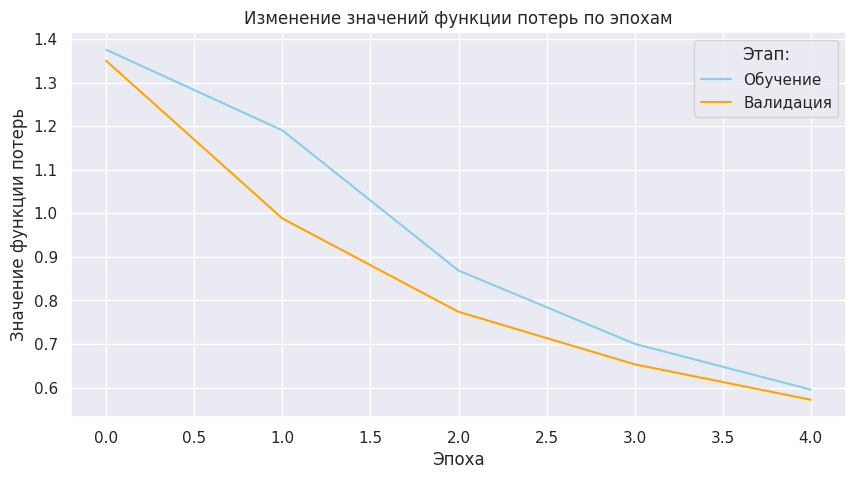

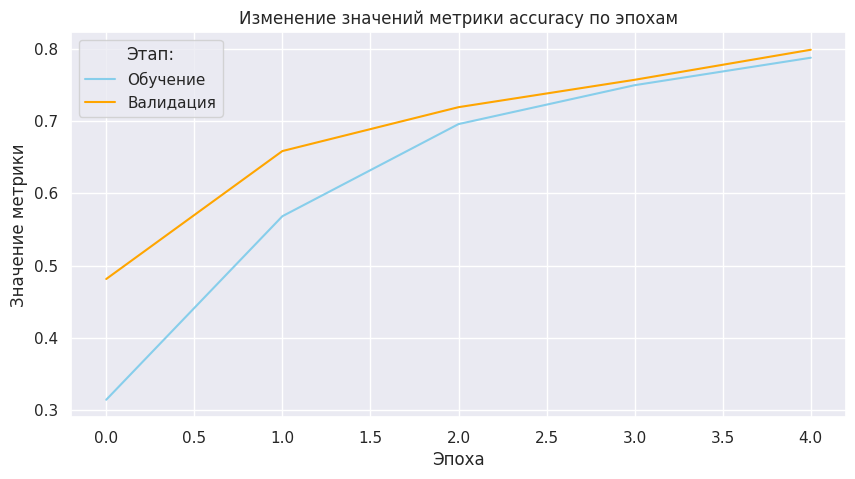

Значение метрики на последней эпохе (валидация): 0.7982890605926514


In [ ]:
show_plots(model)

Архитектура GRU:

In [ ]:
num_epoch = 13
hidden_dim = 128
dropout_rate = 0
num_layers = 1
bidirectional = False
arch = 'GRU'
aggregation_type = 'max'
learning_rate = 2e-5

In [ ]:
model = Classifier(arch=arch,
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [ ]:
trainer = L.Trainer(max_epochs=num_epoch,
                    accelerator='gpu',
                    log_every_n_steps=10,
                    gradient_clip_val=0.5)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0      | train
1 | metric     | MulticlassAccuracy | 0      | train
2 | embedding  | Embedding          | 1.5 M  | train
3 | rnn        | GRU                | 99.1 K | train
4 | linear     | Linear             | 16.5 K | train
5 | projection | Linear             | 516    | train
6 | non_lin    | Tanh               | 0      | train
7 | dropout    | Dropout            | 0      | train
----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.528     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=13` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=13` reached.


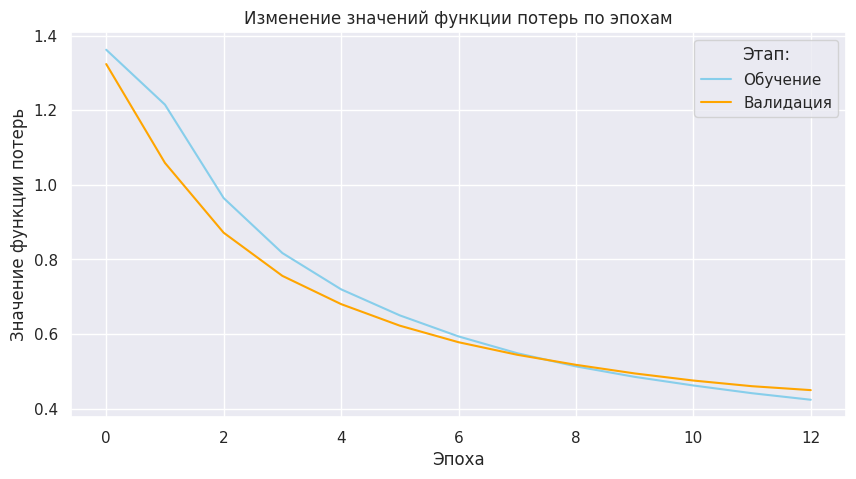

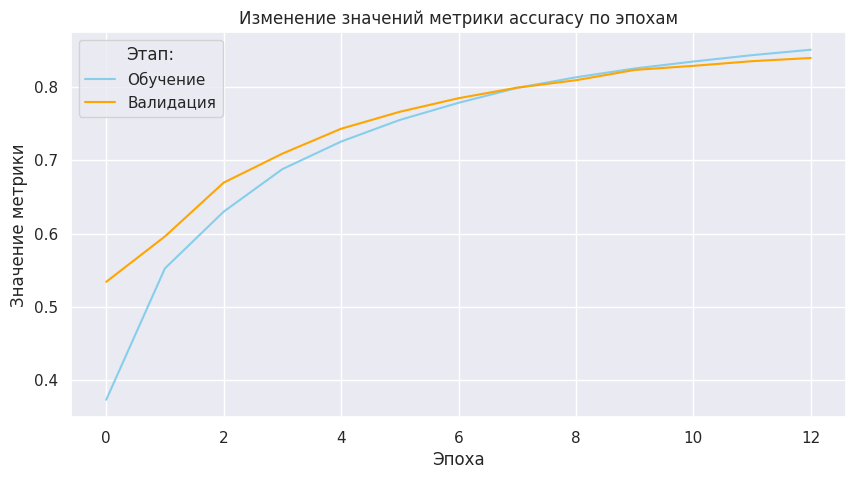

Значение метрики на последней эпохе (валидация): 0.8392400741577148


In [ ]:
show_plots(model)

Архитектура GRU показала себя лучше. В дальнейших экспериментах будем использовать ее. Попробуем увеличить количество слоев.

Используем предобученные вектора FastText

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296188 sha256=b3182a984456b6fa8bc7f483a0eeb27a15e8feb4b14d8eeec098551fd06ee74a
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
import fasttext.util

In [ ]:
num_epoch = 15
hidden_dim = 256
dropout_rate = 0.1
num_layers = 3
bidirectional = True
arch = 'GRU'
aggregation_type = 'max'
learning_rate = 0.7e-5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fasttext.util.download_model('en', if_exists='ignore')  # English
vectorizer = fasttext.load_model('cc.en.300.bin')

In [ ]:
vectorizer = fasttext.load_model('cc.en.300.bin')

In [ ]:
emb = [vectorizer.get_word_vector(word) for _, word in ind2word.items()]

In [ ]:
del vectorizer
emb = torch.tensor(np.vstack(emb))

In [ ]:
model = Classifier(arch=arch,
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate,
                   embedding_vectors=emb)
trainer = L.Trainer(max_epochs=num_epoch,
                    accelerator='gpu',
                    log_every_n_steps=10,
                    gradient_clip_val=0.5)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0      | train
1 | metric     | MulticlassAccuracy | 0      | train
2 | embedding  | Embedding          | 3.6 M  | train
3 | rnn        | GRU                | 3.2 M  | train
4 | linear     | Linear             | 131 K  | train
5 | projection | Linear             | 1.0 K  | train
6 | non_lin    | Tanh               | 0      | train
7 | dropout    | Dropout            | 0      | train
----------------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.630    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [ ]:
evaluate(model, eval_dataloader)

0.9057999849319458

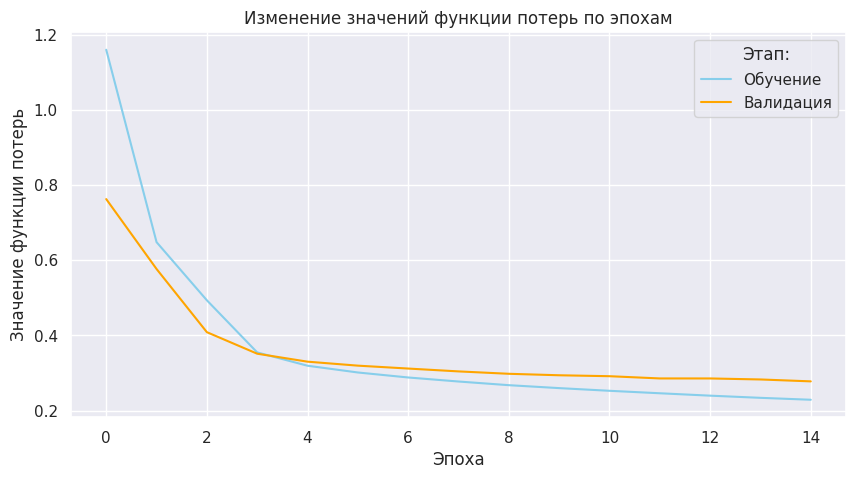

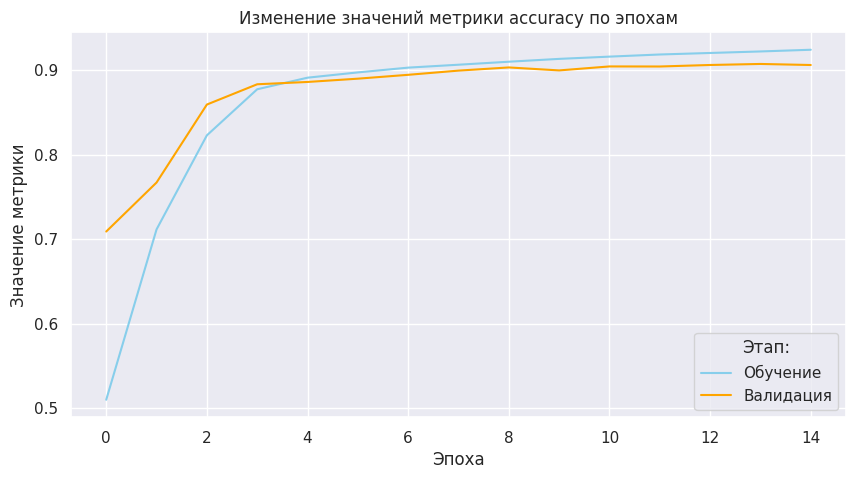

Значение метрики на последней эпохе (валидация): 0.9062941074371338


In [ ]:
show_plots(model)

Лучшей оказалась модель GRU с использованием FastText. Скор: 0.906

Результаты улучшились после перехода с полносвязной сети на RNN, перехода на архитектуру GRU и использования FastText.
Сходимость методов стабильная.